# MRIReco.jl
#### Julia package for MRI reconstruction

by Tobias Knopp and Mirco Grosser

## Overview

* Getting Started
* Introduction to Julia
* MRIReco: Architecture
* MRIReco: Examples


# Getting Started

There are two ways get started with this tutorial
* Download Julia, install the packages and enter the commands into the Julia REPL
* Use the [binder](https://mybinder.org/v2/gh/MagneticResonanceImaging/MRIRecoTutorial/master) and go through this in the web browser.

  [https://mybinder.org/v2/gh/MagneticResonanceImaging/MRIRecoTutorial/master](https://mybinder.org/v2/gh/MagneticResonanceImaging/MRIRecoTutorial/master)
  
The binder solution requires no installation, but we highly recommend installing Julia to get a better picture of the language

# Installing Julia

* Go to [https://julialang.org/downloads/](https://julialang.org/downloads/) and download the most recent stable release
* Start Julia from within a terminal
* We need to install some packages. With ] we can enter the Pkg mode and then add packages with `add PackageName`
* We add the packages `Plots`, `Images`, `FFTW`, `NFFT`, `Wavelets`, `LinearOperators`, `MRIReco`

# Julia

* High level programming language with Matlab like syntax
* Provides a powerful REPL for interactive use
* Strongly influenced by C++ and Python
* Generates efficient machine code:
  no need to write perfromance critical things in C/C++

### In a nutshell: 

### Julia = (C++ $\cup$ Python $\cup$ Matlab) $\cap$ OnlyTheNiceThings

# Julia Tooling

Commonly Julia is developed in

* Packages: Several source files / modules grouped together
* Scripts: Usually load packages an perform a dedicated operation

Both can be interactively executed on the REPL. 

Within this tutorial, we will, however use a Jupyter notebook instead (not our usual workflow)

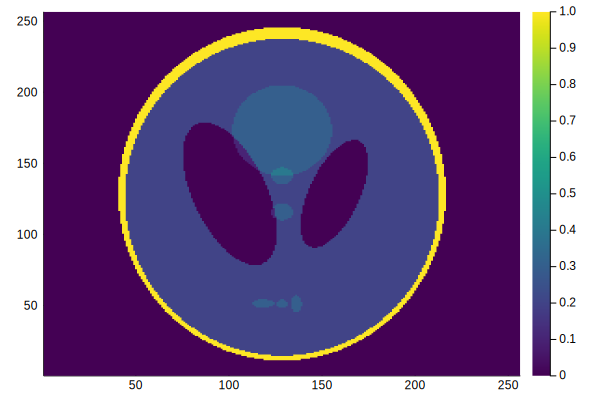

In [12]:
using Images
using Plots

p = shepp_logan(256)

heatmap(reverse(p,dims=1), c=:viridis)

Lets do some image processing

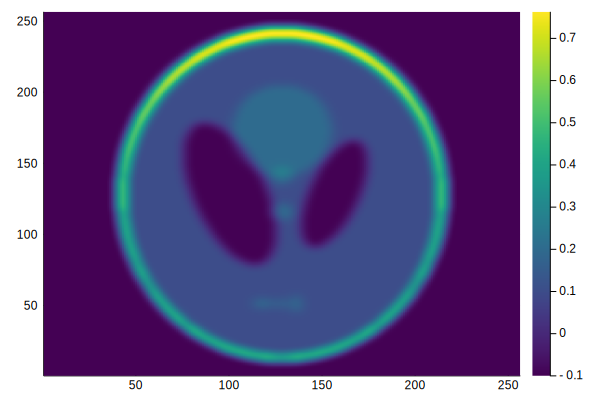

In [13]:
pfilt = imfilter(p,Kernel.gaussian(3))

heatmap(reverse(pfilt,dims=1).-0.1, c=:viridis)

Lets switch into frequency space

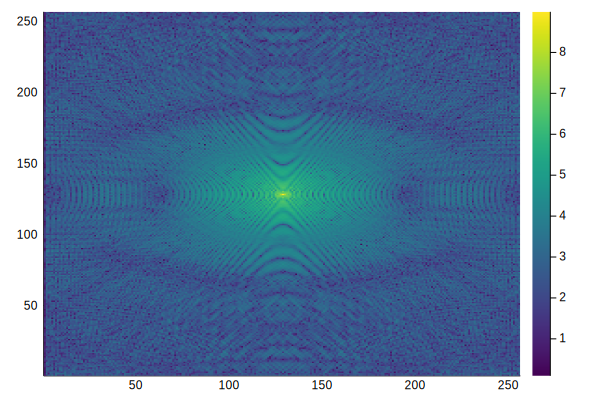

In [14]:
using FFTW

pFT = fftshift( fft(p) )
heatmap(reverse(log.(abs.(pFT).+1.1),dims=1), c=:viridis)

Or lets look at the wavelet transform

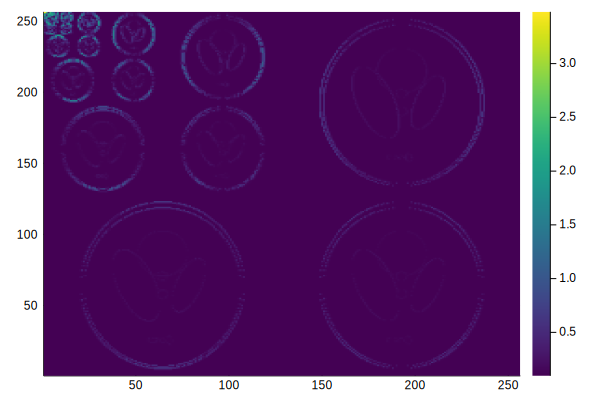

In [15]:
using Wavelets

pW = dwt(p, wavelet(WT.db2))
heatmap(reverse(log.(abs.(pW).+1.1),dims=1), c=:viridis)

# Dot syntax

What is that for a strange dot before the log and abs?

In [4]:
methods(abs)

# 23 methods for generic function "abs":
[1] abs(x::Bool) in Base at bool.jl:91
[2] abs(x::Float16) in Base at float.jl:520
[3] abs(x::Float32) in Base at float.jl:521
[4] abs(x::Float64) in Base at float.jl:522
[5] abs(::Missing) in Base at missing.jl:83
[6] abs(a::Pkg.Resolve.VersionWeights.VersionWeight) in Pkg.Resolve.VersionWeights at /Users/osx/buildbot/slave/package_osx64/build/usr/share/julia/stdlib/v1.1/Pkg/src/resolve/VersionWeights.jl:40
[7] abs(a::Pkg.Resolve.MaxSum.FieldValues.FieldValue) in Pkg.Resolve.MaxSum.FieldValues at /Users/osx/buildbot/slave/package_osx64/build/usr/share/julia/stdlib/v1.1/Pkg/src/resolve/FieldValues.jl:67
[8] abs(a::PyCall.PyObject) in PyCall at /Users/knopp/.julia/packages/PyCall/ttONZ/src/pyoperators.jl:41
[9] abs(x::Unsigned) in Base at int.jl:135
[10] abs(x::Signed) in Base at int.jl:136
[11] abs(x::Rational) in Base at rational.jl:231
[12] abs(x::Fixed{T,f}) where {T, f} in FixedPointNumbers at /Users/knopp/.julia/packages/FixedPointNumbers/3QAEg/src/fixed.jl:34
[13] abs(x::Normed) in FixedPointNumbers at /Users/knopp/.julia/packages/FixedPointNumbers/3QAEg/src/normed.jl:86
[14] abs(x::Real) in Base at number.jl:144
[15] abs(z::Complex) in Base at complex.jl:260
[16] abs(a::T) where T<:Dates.Period in Dates at /Users/osx/buildbot/slave/package_osx64/build/usr/share/julia/stdlib/v1.1/Dates/src/periods.jl:97
[17] abs(c::AbstractRGB{T}) where T<:Normed in ColorVectorSpace at /Users/knopp/.julia/packages/ColorVectorSpace/HeIVH/src/ColorVectorSpace.jl:164
[18] abs(c::AbstractRGB) in ColorVectorSpace at /Users/knopp/.julia/packages/ColorVectorSpace/HeIVH/src/ColorVectorSpace.jl:163
[19] abs(c::TransparentColor{C,T,4} where T where C<:AbstractRGB) in ColorVectorSpace at /Users/knopp/.julia/packages/ColorVectorSpace/HeIVH/src/ColorVectorSpace.jl:165
[20] abs(c::TransparentColor{T,T1,4} where T1) where T<:Normed in ColorVectorSpace at /Users/knopp/.julia/packages/ColorVectorSpace/HeIVH/src/ColorVectorSpace.jl:166
[21] abs(c::Color{T,1} where T) in ColorVectorSpace at /Users/knopp/.julia/packages/ColorVectorSpace/HeIVH/src/ColorVectorSpace.jl:210
[22] abs(c::TransparentColor{C,T,2} where T<:Normed where C<:(Color{T,1} where T)) in ColorVectorSpace at /Users/knopp/.julia/packages/ColorVectorSpace/HeIVH/src/ColorVectorSpace.jl:253
[23] abs(c::TransparentColor{C,T,2} where T where C<:(Color{T,1} where T)) in ColorVectorSpace at /Users/knopp/.julia/packages/ColorVectorSpace/HeIVH/src/ColorVectorSpace.jl:252

# Dot syntax

No vectorized version? It seems that the . operator can be applied to any scalar function:

In [5]:
myfunc(x::Number) = 5*x

a = ones(3)
myfunc(a)

MethodError: MethodError: no method matching myfunc(::Array{Float64,1})
Closest candidates are:
  myfunc(!Matched::Number) at In[5]:1

In [6]:
myfunc.(a)

3-element Array{Float64,1}:
 5.0
 5.0
 5.0

# Multiple Dispatch

Julia uses multiple dispatch to decide, which method is called

In [20]:
using SparseArrays

function myfunc(a::AbstractMatrix{T}) where T<:Number
  # generic fallback
end

function myfunc(a::StridedMatrix{T}) where T<:Number
  # call BLAS routines
end

function myfunc(a::SparseMatrixCSC{T}) where T<:Number
  # exploit sparsity
end

myfunc (generic function with 3 methods)

# How low level is Julia?

You can directly call C code with 0 overhead

In [23]:
t = ccall((:clock, "libc"), Int32, ())

301190089

# How low level is Julia?

One can look at the assembly code

In [26]:
double(x) = 2*x
@code_native double(2)

	.section	__TEXT,__text,regular,pure_instructions
; ┌ @ In[26]:1 within `double'
; │┌ @ In[26]:1 within `*'
	decl	%eax
	leal	(%edi,%edi), %eax
; │└
	retl
	nopw	%cs:(%eax,%eax)
; └


In [25]:
@code_native double(2.0)

	.section	__TEXT,__text,regular,pure_instructions
; ┌ @ In[24]:1 within `double'
; │┌ @ promotion.jl:314 within `*' @ In[24]:1
	vaddsd	%xmm0, %xmm0, %xmm0
; │└
	retl
	nopw	%cs:(%eax,%eax)
; └


# MRIReco.jl

* Julia package intending to provide a powerfull MRI reconstruction toolbox
* In development (not as stable / feature complete as Gadgetron / BART)
* Focus on reconstruction researchers providing a hackable package
* Modular concept using existing goodies from Julialand

# MRIReco.jl

The following packages are used / outsourced so that MRIReco.jl can concentrate on glueing the pieces together

* FFTW.jl
* NFFT.jl
* Wavelets.jl
* LinearOperators.jl
* NIfTI.jl
* HDF5.jl
* LightXML.jl
* RegularizedLeastSquares.jl
* Images.jl

# Dependency Graph

![alt text](img/Dependencies.svg)

# Data Types and Flow

Basic overview of the data flow during reconstruction

![alt text](img/AcqObj.svg)

# Get Data

Lets get some data first

In [31]:
using HTTP

if !isdir("brukerfileCart")
  HTTP.open("GET", "http://media.tuhh.de/ibi/mrireco/brukerfileCart.zip") do http
    open("brukerfileCart.zip", "w") do file
        write(file, http)
    end
  end
  run(`unzip brukerfileCart.zip`)
end

filename = "simple_spiral.h5"
if !isfile(filename)
  HTTP.open("GET", "https://netix.dl.sourceforge.net/project/ismrmrd/data/simple_spiral.h5") do http
    open(filename, "w") do file
      write(file, http)
    end
  end
end

HTTP.Messages.Response:
"""
HTTP/1.1 200 OK
Server: nginx/1.14.0 (Ubuntu)
Date: Fri, 03 May 2019 15:11:10 GMT
Content-Type: application/octet-stream
Content-Length: 42331912
Connection: keep-alive
Last-Modified: Sat, 06 Jul 2013 16:37:52 GMT
ETag: "51d847e0-285ef08"
Accept-Ranges: bytes

"""

# Example

The following code example goes through all layers

In [28]:
using MRIReco

# File loading
f = BrukerFile("brukerfileCart")
raw = RawAcquisitionData(f)
acq = AcquisitionData(raw)

# Reconstruction
params = Dict{Symbol, Any}()
params[:reco] = "direct"
params[:shape] = (acq.encodingSize[1],acq.encodingSize[2])
Ireco = reconstruction(acq, params)

# Image handling
saveImage("reco.nii", Ireco, true);

# File Handling

Lets go through this step by step

In [29]:
using MRIReco

f = BrukerFile("brukerfileCart")
raw = RawAcquisitionData(f);

The `RawAcquisitionData` has a similar design as an ISMRMRD data file.
It has two members:
* `raw.params` is a dict that holds general parameter of the file
* `raw.profiles` is a vector with all measured profles

In [4]:
raw.params

Dict{String,Any} with 18 entries:
  "institutionName"         => "Luebeck"
  "sequence_type"           => "T2_RARE"
  "echo_spacing"            => 17.0
  "stationName"             => "ICON 1T"
  "studyID"                 => "mk190404a"
  "seriesDescription"       => "T2_RARE (E2)"
  "TR"                      => 3221.44
  "TE"                      => 85.0
  "measurementID"           => 2
  "H1resonanceFrequency_Hz" => 178492384
  "patientName"             => "mouse head ex vivo"
  "receiverChannels"        => 1
  "trajectory"              => "cartesian"
  "referringPhysicianName"  => "nmrsu"
  "flipAngle_deg"           => 90.0
  "encodedFOV"              => [0.027, 0.027, 0.0125]
  "systemVendor"            => "Bruker"
  "encodedSize"             => [96, 96, 1]

In [5]:
length(raw.profiles)

1440

In [6]:
raw.profiles[1]

MRIReco.Profile(AcquisitionHeader(0, 0, 0, 0, 0, (0, 0, 0), 96, 0, 0, (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0), 0, 0, 48, 0, 0, 0.0f0, (1.4791f0, -11.53317f0, 7.52411f0), (0.0f0, 0.0f0, 1.0f0), (1.0f0, 0.0f0, 0.0f0), (0.0f0, 1.0f0, 0.0f0), (0.0f0, 0.0f0, 0.0f0), EncodingCounters(13, 0, 0, 0, 0, 0, 0, 0, 0, (0, 0, 0, 0, 0, 0, 0, 0)), (0, 0, 0, 0, 0, 0, 0, 0), (0.0f0, 0.0f0, 0.0f0, 0.0f0, 0.0f0, 0.0f0, 0.0f0, 0.0f0)), Array{Float32}(0,0), Complex{Float32}[1411.0-1605.0im; -355.0-34.0im; … ; 54.0+954.0im; -1728.0-1602.0im])

# Reconstruction

Next we will reconstruct the data. To do so we first convert the raw acquisition data
object into an acquisition data object. This will reorder the data in such a way, that
the reconstruction knows how to deal with it.

In [7]:
acq = AcquisitionData(raw);

Now we can perform the reconstruction. It can be controlled using a dictionary of parameters

In [8]:
params = Dict{Symbol, Any}()
params[:reco] = "direct"
params[:shape] = (acq.encodingSize[1],acq.encodingSize[2]);

Ireco = reconstruction(acq, params);

Direct Reconstruction...100%|███████████████████████████| Time: 0:00:03


# Image Data

Lets have a look what the return type of `reconstruction` is

In [14]:
typeof(Ireco)

AxisArray{Complex{Float64},5,Array{Complex{Float64},5},Tuple{Axis{:x,StepRangeLen{Quantity{Float64,𝐋,Unitful.FreeUnits{(mm,),𝐋,nothing}},Base.TwicePrecision{Quantity{Float64,𝐋,Unitful.FreeUnits{(mm,),𝐋,nothing}}},Base.TwicePrecision{Quantity{Float64,𝐋,Unitful.FreeUnits{(mm,),𝐋,nothing}}}}},Axis{:y,StepRangeLen{Quantity{Float64,𝐋,Unitful.FreeUnits{(mm,),𝐋,nothing}},Base.TwicePrecision{Quantity{Float64,𝐋,Unitful.FreeUnits{(mm,),𝐋,nothing}}},Base.TwicePrecision{Quantity{Float64,𝐋,Unitful.FreeUnits{(mm,),𝐋,nothing}}}}},Axis{:z,StepRangeLen{Quantity{Float64,𝐋,Unitful.FreeUnits{(mm,),𝐋,nothing}},Base.TwicePrecision{Quantity{Float64,𝐋,Unitful.FreeUnits{(mm,),𝐋,nothing}}},Base.TwicePrecision{Quantity{Float64,𝐋,Unitful.FreeUnits{(mm,),𝐋,nothing}}}}},Axis{:echos,UnitRange{Int64}},Axis{:coils,UnitRange{Int64}}}}

Seems to be complicated but its just a 5 dimensional array with names axis. You can access the raw array by

# Image Data

In [15]:
Ireco.data

96×96×15×1×1 Array{Complex{Float64},5}:
[:, :, 1, 1, 1] =
  0.141069-8.52366im     -8.33367+2.46909im   …   0.795356-3.33902im 
  -3.96558+1.36755im     -7.49569+1.45612im       -3.29382+0.721533im
  -3.08149+3.27818im     -5.33986-2.48764im        5.37037+11.2086im 
  -6.39724+3.16952im     -2.81512-0.935448im      -1.41585-8.38762im 
   10.4533+0.0780348im   0.151835+1.73939im      -0.909479-4.35625im 
  -2.16532-11.9359im     -2.83795+0.67595im   …    8.07904-8.9921im  
   12.8764-15.9769im    -0.654643-10.7817im        5.50739-7.94453im 
   18.0205-7.19996im      17.7163-1.76398im       -2.83716-0.74465im 
 -0.501561-12.5255im      1.07335+2.20741im       -6.67839-8.20009im 
   11.1895-7.39392im    -0.218618-8.27117im        18.5894+16.4204im 
  -7.92216-7.84242im      9.36307-14.384im    …   0.865124-9.81026im 
   6.43944-14.7517im     -12.7065-17.8374im        2.30926-14.0661im 
   18.2659-10.1153im      4.86421-3.20785im       -1.25431+1.5332im  
          ⋮                     

# Image Data

What are the dimensions of the reconstructed data?

In [16]:
size(Ireco)

(96, 96, 15, 1, 1)

So its $96 \times 96$ data with $15$ slices

What were the axis good for?

In [12]:
Images.axisnames(Ireco)

(:x, :y, :z, :echos, :coils)

# Image Data

The image data can be stored into a NIfTI file by calling

In [17]:
saveImage("reco.nii", Ireco, true);

To load this image back just call

In [18]:
Ireco = loadImage("reco.nii")

96×96×15×1×1 AxisArray{Float64,5,Array{Float64,5},Tuple{Axis{:x,StepRangeLen{Quantity{Float64,𝐋,Unitful.FreeUnits{(mm,),𝐋,nothing}},Base.TwicePrecision{Quantity{Float64,𝐋,Unitful.FreeUnits{(mm,),𝐋,nothing}}},Base.TwicePrecision{Quantity{Float64,𝐋,Unitful.FreeUnits{(mm,),𝐋,nothing}}}}},Axis{:y,StepRangeLen{Quantity{Float64,𝐋,Unitful.FreeUnits{(mm,),𝐋,nothing}},Base.TwicePrecision{Quantity{Float64,𝐋,Unitful.FreeUnits{(mm,),𝐋,nothing}}},Base.TwicePrecision{Quantity{Float64,𝐋,Unitful.FreeUnits{(mm,),𝐋,nothing}}}}},Axis{:z,StepRangeLen{Quantity{Float64,𝐋,Unitful.FreeUnits{(mm,),𝐋,nothing}},Base.TwicePrecision{Quantity{Float64,𝐋,Unitful.FreeUnits{(mm,),𝐋,nothing}}},Base.TwicePrecision{Quantity{Float64,𝐋,Unitful.FreeUnits{(mm,),𝐋,nothing}}}}},Axis{:echos,UnitRange{Int64}},Axis{:coils,UnitRange{Int64}}}}:
[:, :, 1, 1, 1] =
  8.52483   8.69175   3.64936   7.39509  …   9.3435    0.579119   3.43244
  4.19476   7.63581   2.55439   3.09505      7.90095   3.86476    3.37193
  4.49912   5.89087   8.2

# Image Data

Lets plot the reconstructed data. We will be using Plots.jl for this

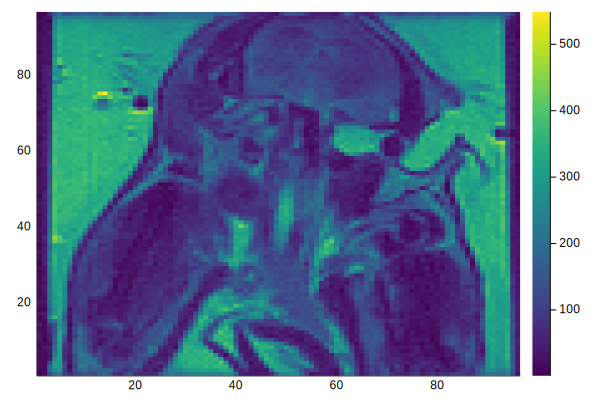

In [13]:
heatmap(reverse( circshift(abs.(Ireco[:,:,10,1,1]),(0,5)),dims=1), c=:viridis)

Bruker does provide reconstruction data as well:

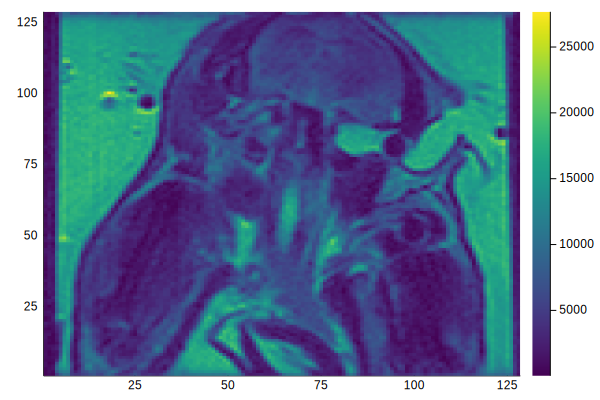

In [16]:
b = BrukerFile("brukerfileCart")
Ibruker = recoData(b)

heatmap(reverse( Ibruker[:,:,10,1,1]',dims=1), c=:viridis)

## Conversion

As we have loaded a `RawAcquistionData` from file, it is also possible to save it.
Currently, it is only possible to save into the ISMRMRD data format, which seems
to be the most sensible choice anyway.

In [17]:
fout = ISMRMRDFile("outputfile.h5")

save(fout, raw);

We may load the data to check that it is still the same:

In [18]:
rawCopy = RawAcquisitionData(fout)

rawCopy.params

Dict{String,Any} with 18 entries:
  "institutionName"         => "Luebeck"
  "sequence_type"           => "T2_RARE"
  "echo_spacing"            => 17.0
  "stationName"             => "ICON 1T"
  "studyID"                 => "mk190404a"
  "seriesDescription"       => "T2_RARE (E2)"
  "TR"                      => 3221.44
  "TE"                      => 85.0
  "measurementID"           => "2"
  "H1resonanceFrequency_Hz" => 178492384
  "patientName"             => "mouse head ex vivo"
  "receiverChannels"        => 1
  "trajectory"              => "cartesian"
  "referringPhysicianName"  => "nmrsu"
  "flipAngle_deg"           => 90.0
  "encodedFOV"              => [0.027, 0.027, 0.0125]
  "systemVendor"            => "Bruker"
  "encodedSize"             => [96, 96, 1]

# Trajectory

Let us access the sampling trajectory

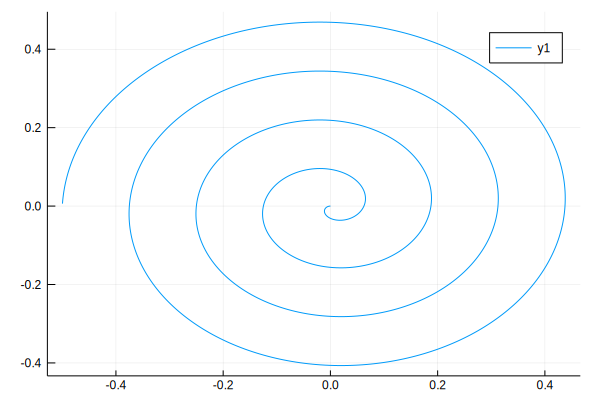

In [34]:
f = ISMRMRDFile("simple_spiral.h5");

acq = AcquisitionData(f)
t = trajectory(acq)
nodes = kspaceNodes(t)

plot(nodes[1,1:909],nodes[2,1:909])

# Develop MRIReco.jl

Changing MRIReco.jl is pretty easy. Go into the package manager and develop the package

In [35]:
] dev MRIReco

┌ Info: Path `/Users/knopp/.julia/dev/MRIReco` exists and looks like the correct package, using existing path
└ @ Pkg.Types /Users/osx/buildbot/slave/package_osx64/build/usr/share/julia/stdlib/v1.1/Pkg/src/Types.jl:645


 Resolving package versions...
  Updating `~/ownCloud/Presentations/Knopp/2019.05.12MRIReco/MRIRecoTutorial/Project.toml`
  [bdf86e05] ~ MRIReco v0.1.0 #master (https://github.com/MagneticResonanceImaging/MRIReco.jl.git) ⇒ v0.1.0 [`~/.julia/dev/MRIReco`]
  Updating `~/ownCloud/Presentations/Knopp/2019.05.12MRIReco/MRIRecoTutorial/Manifest.toml`
  [bdf86e05] ~ MRIReco v0.1.0 #master (https://github.com/MagneticResonanceImaging/MRIReco.jl.git) ⇒ v0.1.0 [`~/.julia/dev/MRIReco`]


In [36]:
] add MRIReco#master

  Updating registry at `~/.julia/registries/General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`
  Updating git-repo `https://github.com/MagneticResonanceImaging/MRIReco.jl.git`
 Resolving package versions...
  Updating `~/ownCloud/Presentations/Knopp/2019.05.12MRIReco/MRIRecoTutorial/Project.toml`
  [bdf86e05] ~ MRIReco v0.1.0 [`~/.julia/dev/MRIReco`] ⇒ v0.1.0 #master (https://github.com/MagneticResonanceImaging/MRIReco.jl.git)
  Updating `~/ownCloud/Presentations/Knopp/2019.05.12MRIReco/MRIRecoTutorial/Manifest.toml`
  [bdf86e05] ~ MRIReco v0.1.0 [`~/.julia/dev/MRIReco`] ⇒ v0.1.0 #master (https://github.com/MagneticResonanceImaging/MRIReco.jl.git)


Now the code is located in

   `/Users/knopp/.julia/dev/MRIReco` 
   
and can be directly modified. 

Note that Julia requires a restart, if you change code. This limitation
can be circumvented by using the `Revise.jl` package (loo at the Github page)

# Iterative Reconstruction
Iterative reconstructions can be performed using a high-level interface. All the relevant reconstruction parameters are collected in a `Dict{Symbol,Any}`. The reconstruction methods use those to formulate the image reconstruction problem and solve it.

To illustrate it, lets consider the following dataset

In [38]:
using MRIReco, Plots
# load fully sampled data
f = ISMRMRDFile("knee_3dFSE_slice170.h5")
acqData = AcquisitionData(f);

For reference, let us reconstruct the fully sampled data

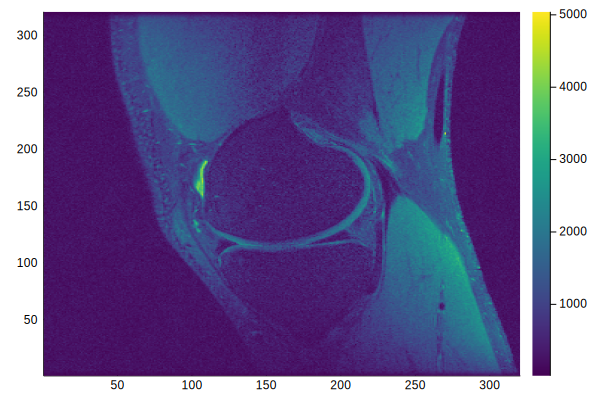

In [39]:
# reconstruct
params = Dict{Symbol, Any}()
params[:reco] = "direct"
params[:shape] = (320,320)
img = reconstruction(acqData, params)
img = sqrt.(sum(img.^2,dims=5))

# show image
heatmap(reverse( abs.(img[:,:,1,1,1]),dims=1), c=:viridis)

To simulate an undersampled reconstruction, we retrospectively undersample the data using a Poisson disk pattern.

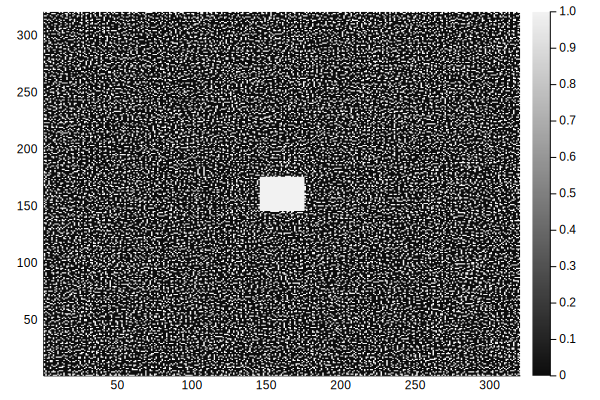

In [8]:
# sampling
redFac= 4.0
acqDataSub = sample_kspace(acqData,redFac,"poisson",calsize=30,profiles=false);

# show sampling pattern
msk = zeros(acqDataSub.encodingSize[1],acqDataSub.encodingSize[2])
msk[acqDataSub.subsampleIndices[1]] .= 1

heatmap(reverse( msk,dims=1), c=:grays)

Estimate the coil sensitivities using ESPIRiT and reconstruct using SENSE

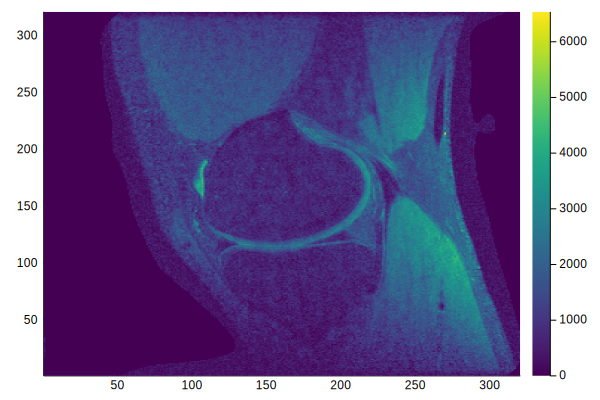

In [9]:
# coil sensitivities
smaps = espirit(acqData,(6,6),30,eigThresh_1=0.035,eigThresh_2=0.98)

# SENSE reconstruction
params = Dict{Symbol, Any}()
params[:reco] = "multiCoil"
params[:solver] = "cgnr"
params[:shape] = (320,320)
params[:regularization] = "L2"
params[:λ] = 1.e-4 #  1.e-1 for L1 || 1.e-4 for L2
params[:iterations] = 5
params[:senseMaps] = smaps
params[:normalizeReg] = true

img_reco = reconstruction(acqDataSub, params)

# show image
heatmap(reverse( abs.(img_reco[:,:,1,1,1]),dims=1), c=:viridis)

Using TV regularization recquires us to change some parameters.

Computing... 32%|████████████▌                          |  ETA: 0:00:48┌ Info: ADMM converged at iteration 17
└ @ RegularizedLeastSquares /Users/knopp/.julia/packages/RegularizedLeastSquares/cgGBJ/src/ADMM.jl:107
Computing...100%|███████████████████████████████████████| Time: 0:00:24


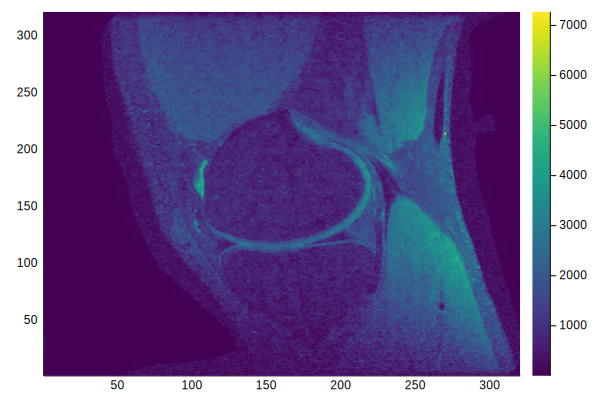

In [10]:
params = Dict{Symbol, Any}()
params[:reco] = "multiCoil"
params[:shape] = (320,320)
params[:solver] = "admm"
params[:regularization] = "TV"
params[:sparseTrafoName] =  "nothing"
params[:λ] = 5.e-2 # 5.e-2
params[:iterations] = 50
params[:ρ] = 0.1
params[:absTol] = 1.e-4
params[:relTol] = 1.e-2
params[:tolInner] = 1.e-2
params[:senseMaps] = smaps
params[:normalizeReg] = true

img_tv = reconstruction(acqDataSub, params)

# show image
heatmap(reverse( abs.(img_tv[:,:,1,1,1]),dims=1), c=:viridis)

Instead of specifying the name of a sparsifying transform or a regularization, these can also be passed directly to the reconstruction.

As an example, let us implement our own Wavelet transform and use it for an L1 regularized reconstruction.

┌ Info: build MyWaveletOp
└ @ Main In[11]:4
Computing...100%|███████████████████████████████████████| Time: 0:00:44


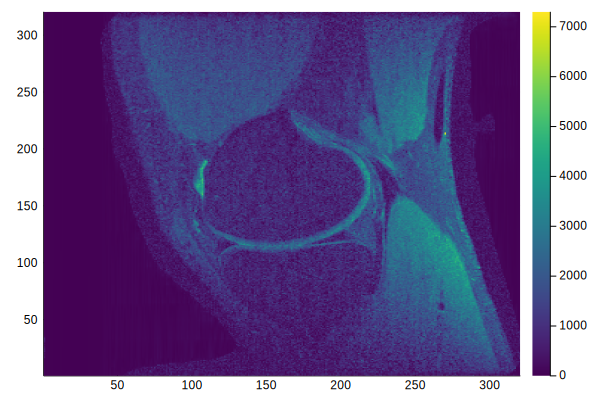

In [11]:
using Wavelets, LinearOperators

function MyWaveletOp(shape, wt=wavelet(WT.db2))
  @info "build MyWaveletOp"
  return LinearOperator(prod(shape),prod(shape),false,false
            , x->dwt(x,wt)
            , nothing
            , x->idwt(x,wt))
end

params = Dict{Symbol, Any}()
params[:reco] = "multiCoil"
params[:shape] = (320,320)
params[:solver] = "admm"
params[:regularization] = "L1"
params[:sparseTrafo] = MyWaveletOp((320,320))
params[:λ] = 5.e-2 # 5.e-2
params[:iterations] = 50
params[:ρ] = 0.1
params[:absTol] = 1.e-4
params[:relTol] = 1.e-2
params[:tolInner] = 1.e-2
params[:senseMaps] = smaps
params[:normalizeReg] = true


img_wt = reconstruction(acqDataSub, params)

# show image
heatmap(reverse( abs.(img_wt[:,:,1,1,1]),dims=1), c=:viridis)